## Date Sequences and Missingness
Per a CDC/GTRI meeting on 10/22/2020, we have decided to examine the HL7 data dates more closely for the purpose of synthetic data generation. Generation around dates require special considerations because certain logical orders/relationships may need to be preserved when generating them synthetically (e.g. One can't be discharged from the hospital before being admitted). 

The notebook explores the following:
- We need to understand missingness overall and by group (by jurisdiction and by condition).
- We also need to understand whether dates can appear before/after one another in the data.

In [1]:
# Imports
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import combinations

In [2]:
# Options to display full tables instead of ellipses
pd.set_option("display.max_columns",50)
pd.set_option("display.max_rows",5000)

In [3]:
# Set path to HL7 Gen Core dataset
GEN_CORE = '../hl7_oct_2020/GenCore.csv'

In [4]:
# These are all of the variables which appear to be a date in the Hl7 data
date_vars = ['Birth_Date',
             'Illness_Onset_Dt',
             'Illness_End_Dt_str',
             'Diag_Dt',
             'Hosp_Admit_Dt',
             'Hosp_Dis_Dt',
             'Invest_Start_Dt',
             'First_Elec_Submit_Dt',
             'Elect_Notif_CDC_Dt',
             'Report_Dt',
             'Earliest_Cnty_Dt',
             'Earliest_State_Dt',
             'MMWR_Year',
             'PHD_Notif_Dt',
             'Message_Dt',
             'msg_received_dttm',
             'mvps_datetime_created',
             'mvps_datetime_updated',
             'current_record_flag', # Here and below are not dates but still needed for groupby operations
             'Report_State_txt',
             'Condition_Code_txt']

In [5]:
core_dts = pd.read_csv(GEN_CORE, usecols = date_vars, dtype = str)

In [6]:
# Apply restrictions that we intend to apply before generating synthetic data

# Exclude rows where current_record_flag is not 'Y'
core_dts = core_dts.loc[core_dts['current_record_flag'] == 'Y  ', :]
core_dts = core_dts.drop(columns = 'current_record_flag')

# Exclude rows where report_dt is missing
#core_dts = core_dts.copy() # to avoid SettingWithCopyWarning
core_dts = core_dts.loc[np.logical_not(core_dts['Report_Dt'].isna()), :]

### Overall Missingness

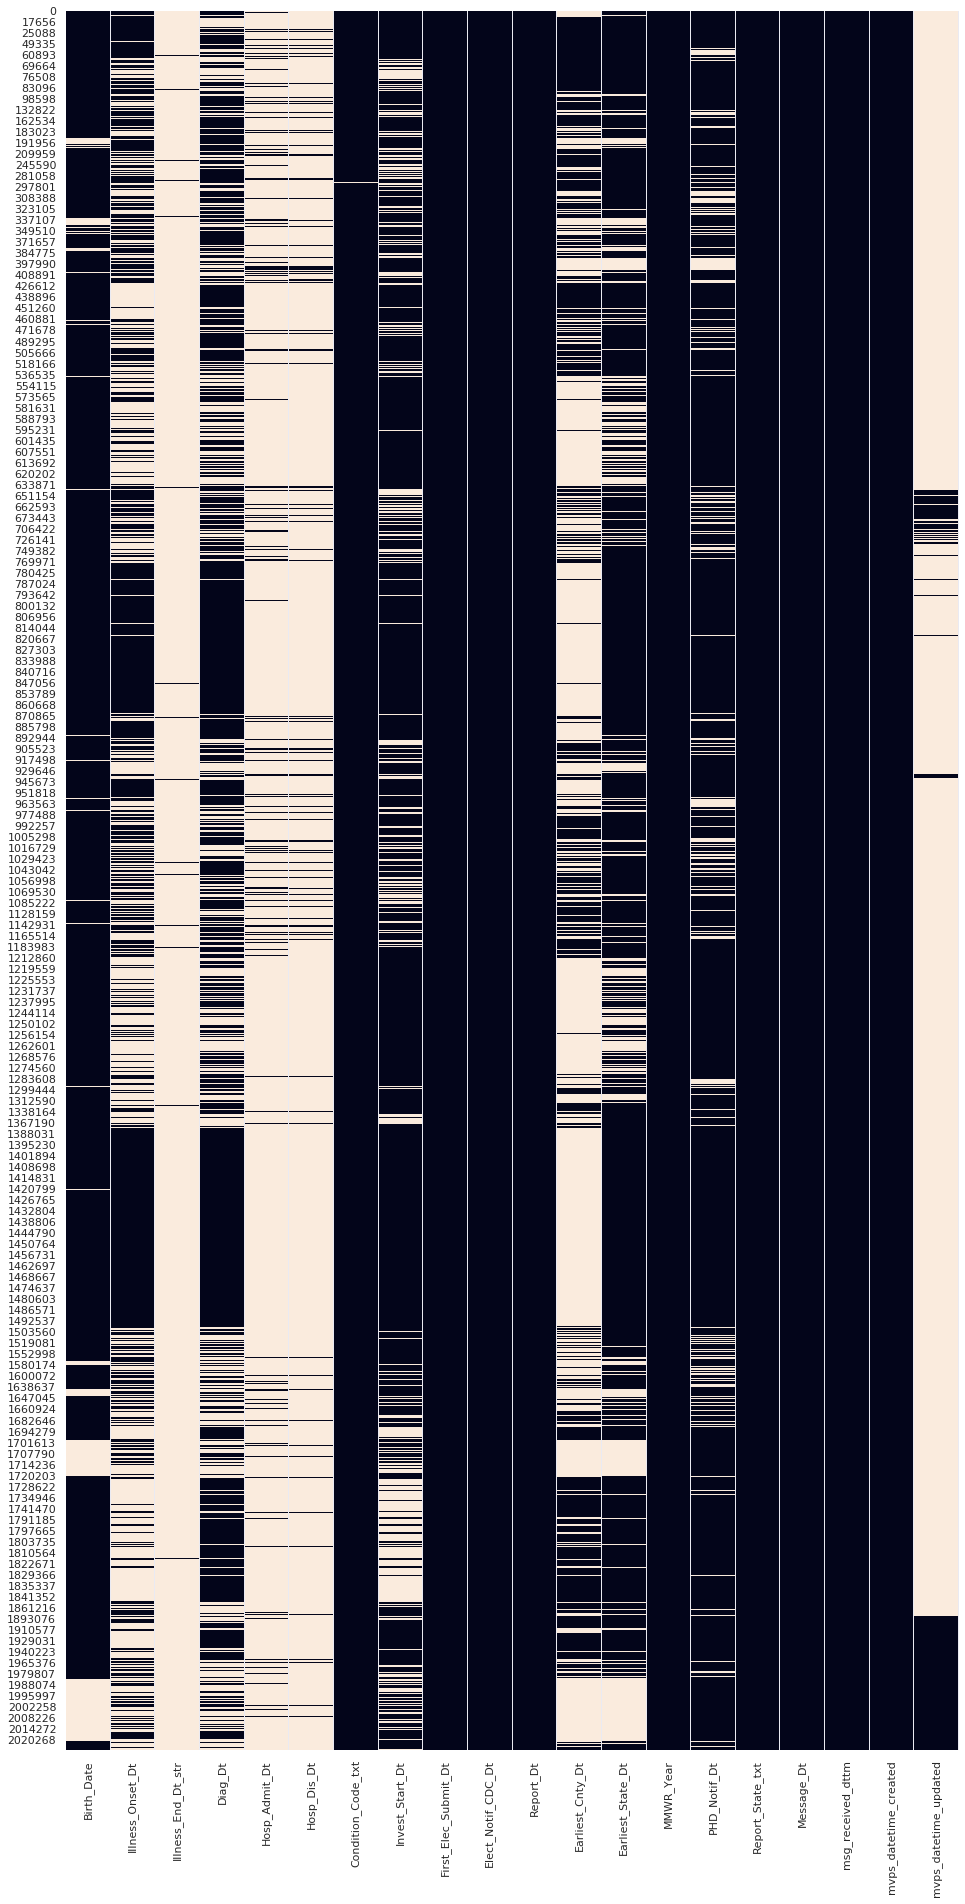

In [7]:
# Missingness "Heatmap" -- Missing is ivory-colored, completed is black
sns.set(rc={'figure.figsize':(16,32)})
sns.heatmap(core_dts.isnull(), cbar=False).figure.savefig("./figures/overall_missingness.png")

In [8]:
# Missing percentages by variable
core_dts.apply(lambda x: sum(x.isnull()) / core_dts.shape[0] * 100)

Birth_Date                8.176795
Illness_Onset_Dt         46.148770
Illness_End_Dt_str       99.107239
Diag_Dt                  31.553860
Hosp_Admit_Dt            91.378257
Hosp_Dis_Dt              93.590160
Condition_Code_txt        0.006365
Invest_Start_Dt          21.117208
First_Elec_Submit_Dt      0.000000
Elect_Notif_CDC_Dt        0.000000
Report_Dt                 0.000000
Earliest_Cnty_Dt         60.523010
Earliest_State_Dt        21.537012
MMWR_Year                 0.029281
PHD_Notif_Dt             10.479194
Report_State_txt          0.000000
Message_Dt                0.000000
msg_received_dttm         0.000000
mvps_datetime_created     0.000000
mvps_datetime_updated    89.705935
dtype: float64

In [9]:
# So, we can set aside these dates that are never missing (or very rarely missing)
not_missing = ['First_Elec_Submit_Dt',
               'Elect_Notif_CDC_Dt',
               'Report_Dt',
               'MMWR_Year',
               'Message_Dt',
               'msg_received_dttm',
               'mvps_datetime_created']

In [10]:
missing = list(set(date_vars) - set(not_missing) - set(['current_record_flag', 'Report_State_txt', 'Condition_Code_txt']))
missing

['Birth_Date',
 'Diag_Dt',
 'Illness_Onset_Dt',
 'Invest_Start_Dt',
 'Illness_End_Dt_str',
 'PHD_Notif_Dt',
 'Earliest_Cnty_Dt',
 'Earliest_State_Dt',
 'mvps_datetime_updated',
 'Hosp_Admit_Dt',
 'Hosp_Dis_Dt']

In [11]:
# Define groupbys

# By diagnosis
dx = core_dts.groupby('Condition_Code_txt')

# By jurisdiction
dj = core_dts.groupby('Report_State_txt')

# By both
dx_dj = core_dts.groupby(['Report_State_txt', 'Condition_Code_txt'])
dj_dx = core_dts.groupby(['Condition_Code_txt', 'Report_State_txt'])

### Missingness by Condition

In [12]:
# Missingness by condition
missing_by_condition = pd.concat([dx[y].apply(lambda x: sum(x.isnull()) / len(x) * 100) for y in missing], axis = 1)
missing_by_condition['sample_size'] = dx.size().values
missing_by_condition

Birth_Date     Diag_Dt  \
Condition_Code_txt                                                           
2019 Novel Coronavirus                                0.000000   35.551664   
2019 Novel Coronavirus (2019-nCoV)                   85.868850   66.410126   
2019 Novel Coronavirus (COVID-19)                     0.000000    1.445783   
2019 Novel Coronavirus (nCoV)                         0.000000   96.815946   
2019-nCoV                                             0.386100   81.930502   
ACUTE FLACCID MYELITIS                                0.000000  100.000000   
AFM                                                   0.000000    0.000000   
Acanthamoeba disease (excluding keratitis)            0.000000  100.000000   
Acute Flaccid Myelitis                                0.000000  100.000000   
Acute Flaccid Myelitis (AFM)                          0.000000   69.230769   
Acute flaccid myelitis                                0.000000  100.000000   
Anaplasma phagocytophilum                            37.637726   42.089026   
Anaplasma phagocytophilum infection                   0.000000   85.714286   
Anaplasmosis                                          0.000000    0.000000   
Anaplasmosis phagocytophilum                          0.000000   22.727273   
Animal Bites                                          0.000000  100.000000   
Anthrax                                               0.000000    0.000000   
BABESIOSIS                                            0.000000    0.148920   
BOTULISM - INFANT                                     0.000000    0.000000   
BRUCELLOSIS                                           0.000000    0.000000   
Babesia                                               0.000000   10.526316   
Babesiosis                                           51.770956   37.750885   
Bacillus anthracis                                    0.000000    0.000000   
Botulism - Infant                                     0.000000   33.333333   
Botulism - Other                                      0.000000   66.666667   
Brucella                                              0.000000    0.000000   
Brucellosis                                           1.807229   65.662651   
Brucellosis not temporally/spatially clustered        0.000000   60.000000   
CAMPYLOBACTERIOSIS                                    0.077477    0.209189   
CHOLERA                                               0.000000    0.000000   
COVID-19                                              3.598201   47.226387   
COVID-19 (CORONA VIRUS)                               2.866242  100.000000   
COVID-19 (CORONAVIRUS)                                1.481429   98.321983   
CP-CRE                                                0.000000   21.311475   
CP-CRE (Pre-2020)*                                    0.602410   39.759036   
CRYPTOSPORIDIOSIS                                     0.040800    0.407997   
CYCLOSPORIASIS                                        0.000000    0.000000   
Campylobacter                                         0.097962   33.398642   
Campylobacteriosis                                   10.770109   58.539732   
Carbapenemase-Producing Carbapenem-Resistant En...    0.000000   33.333333   
Carbon Monoxide Poisoning                             0.000000    0.480769   
Chancroid                                             0.000000  100.000000   
Chlamydia                                             0.000000    0.080159   
Chlamydia trachomatis                                 0.161921    1.506565   
Chlamydia trachomatis infection                       0.023587   23.826336   
Chlamydophila psittaci                                0.000000   50.000000   
Cholera                                               0.000000    0.000000   
Cholera (toxigenic Vibrio cholerae O1 or O139)       11.111111   44.444444   
Chronic hepatitis B                                   0.178253   48.128342   
Clostridium botulinum                                 0.000000   50.000000

In [13]:
# Export table
missing_by_condition.to_csv('./datasets/missing_by_condition.csv')

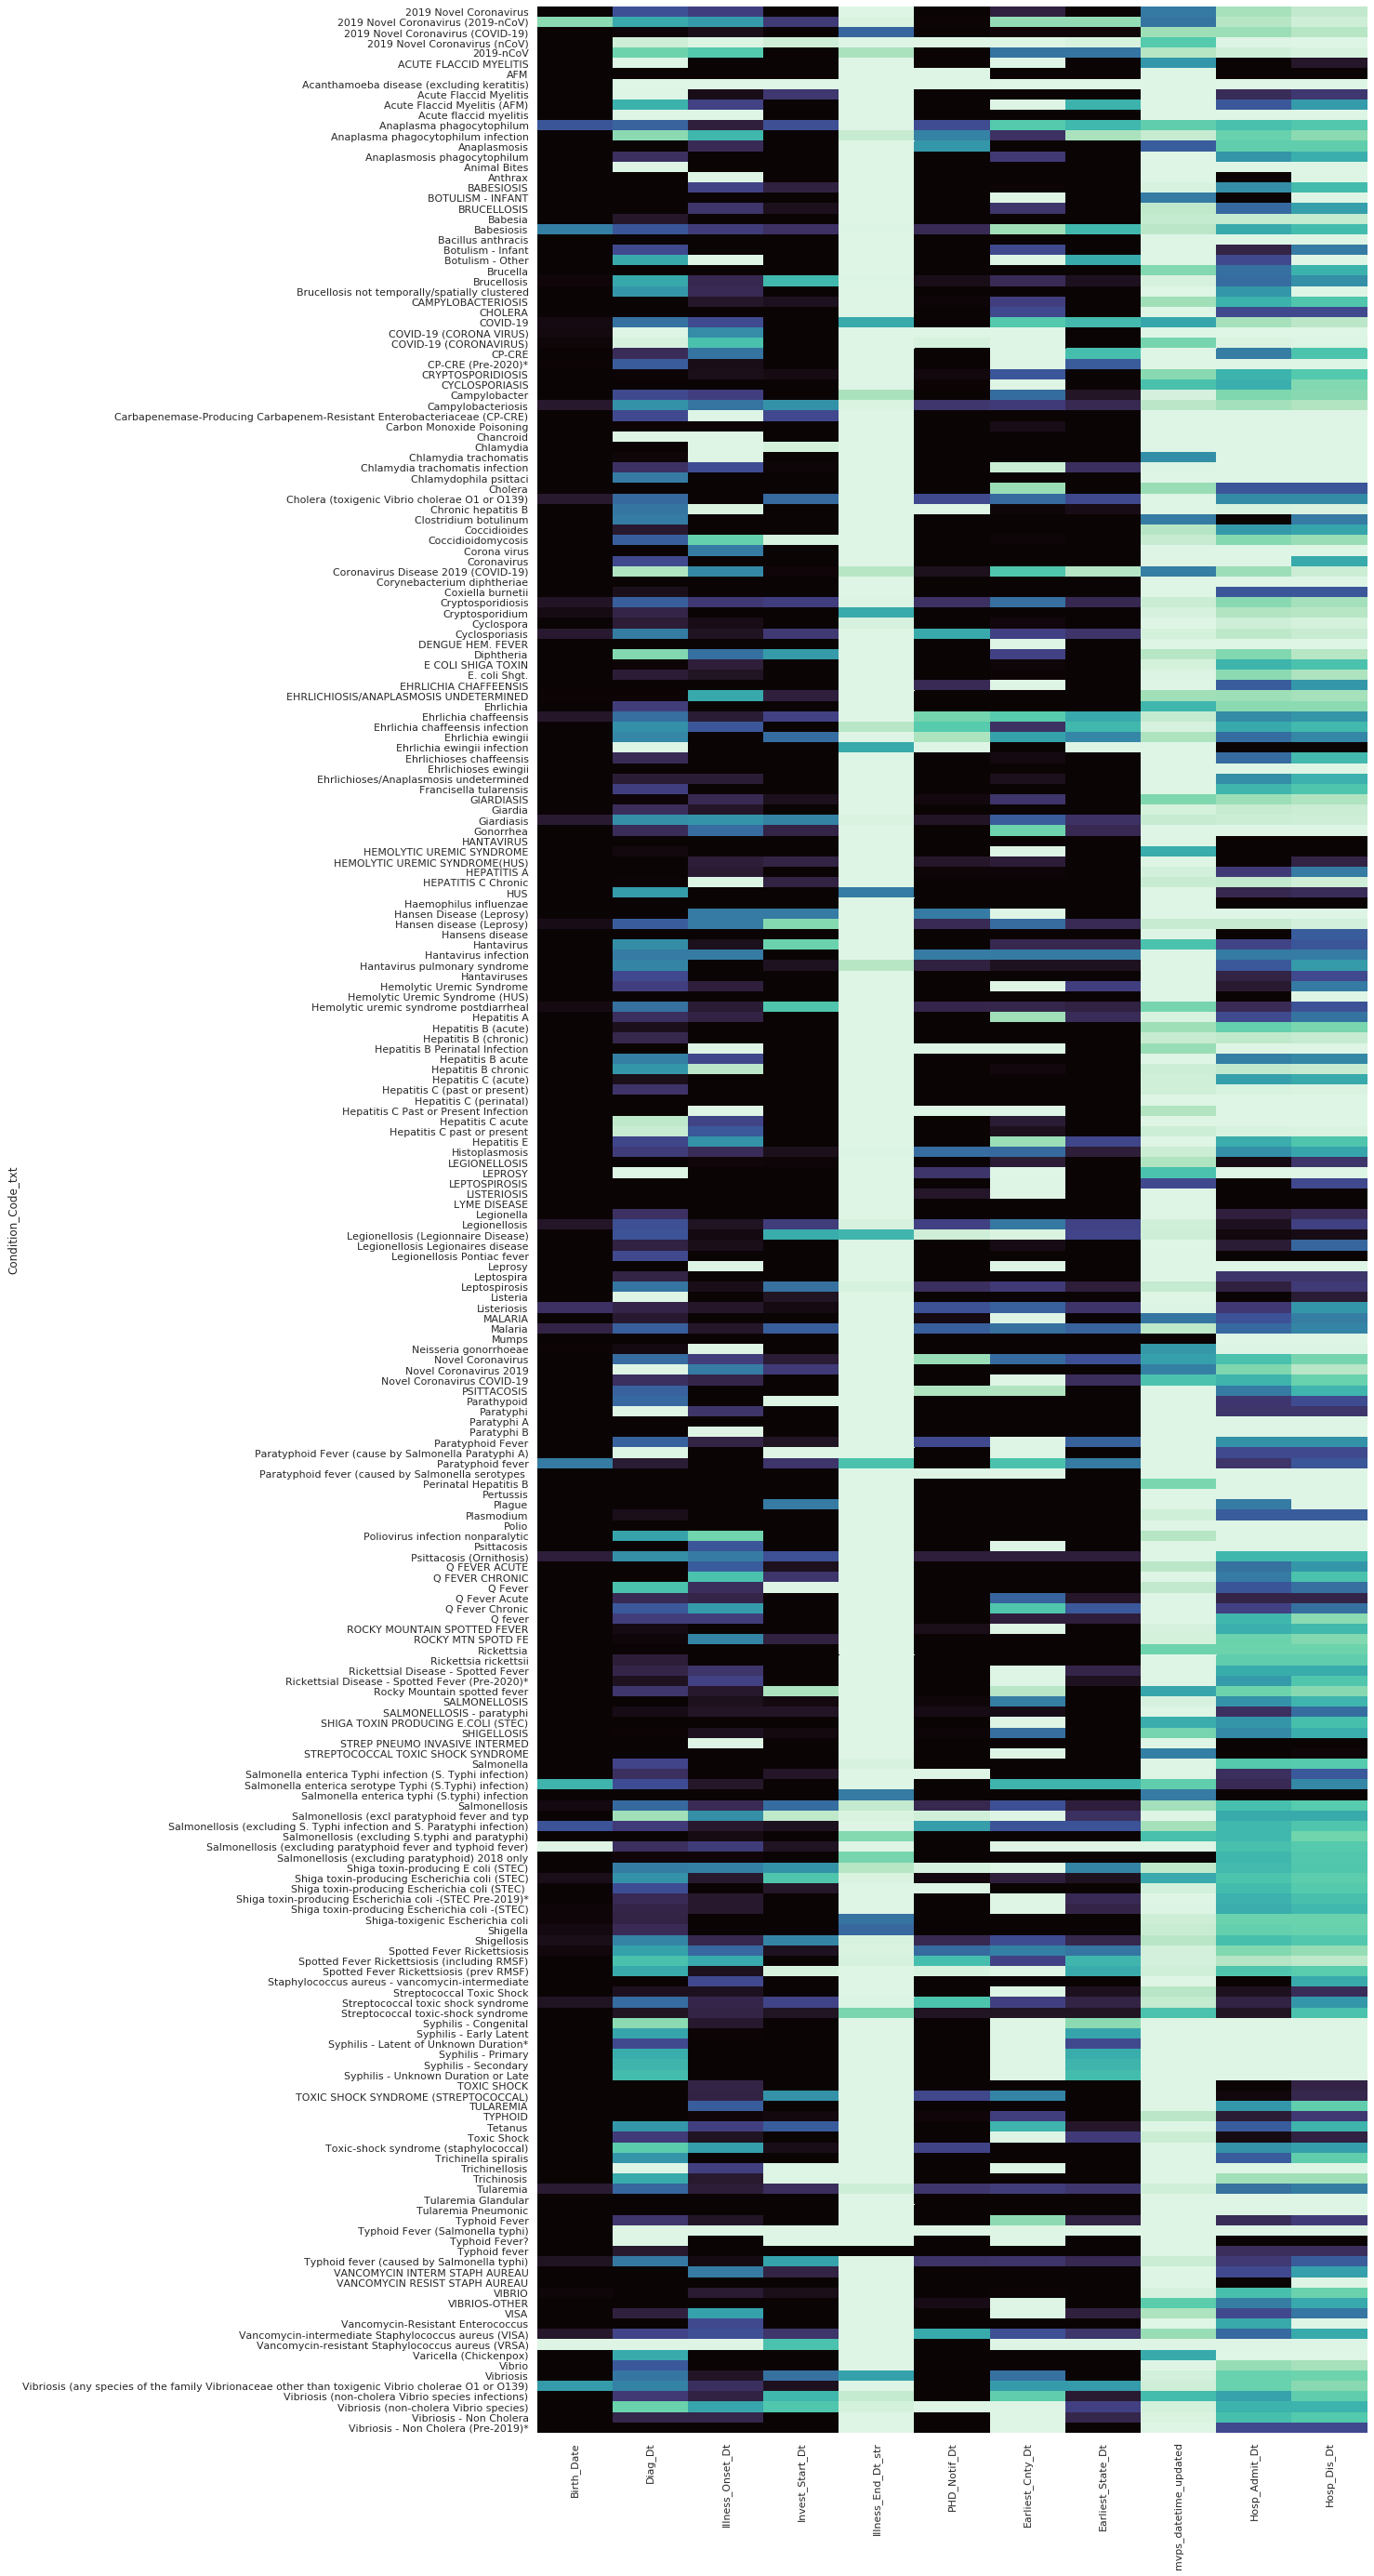

In [14]:
sns.set(rc={'figure.figsize':(16,48)})
sns.heatmap(missing_by_condition.drop(columns='sample_size'), cbar = False, cmap = "mako").figure.savefig("./figures/missing_by_condition.png")

### Missingness by Jurisdiction

In [15]:
# Missingness by jurisdiction
missing_by_jurisdiction = pd.concat([dj[y].apply(lambda x: sum(x.isnull()) / len(x) * 100) for y in missing], axis = 1)
missing_by_jurisdiction['sample_size'] = dj.size().values
missing_by_jurisdiction

Birth_Date     Diag_Dt  Illness_Onset_Dt  Invest_Start_Dt  \
Report_State_txt                                                              
Alabama             0.000000    2.928870          2.928870         0.000000   
Alaska              0.000000   85.438972         18.736617       100.000000   
Arizona             0.000000   37.500000         62.500000        25.000000   
CT                  0.059589   94.637005         66.511074       100.000000   
California          0.262038   64.131418         56.851556       100.000000   
Colorado            0.170960   99.937833         40.828379        22.446284   
Delaware            0.000000   82.686308         85.961872        86.100520   
Florida             0.000000  100.000000        100.000000       100.000000   
Georgia             0.817321   50.126768         37.316520         0.000000   
Idaho               0.086308   20.689230         91.609642         0.012330   
Illinois            0.061317   31.893063          0.000000        17.266893   
Indiana             0.000000   48.915663         59.036145         0.000000   
Iowa                0.014969   52.578400         44.465235         0.000000   
Kentucky            0.291121   24.599709         35.953421         0.000000   
Louisiana           0.067674    0.092282         99.624719         0.000000   
Maine               0.035689    8.850821          8.708066         0.000000   
Massachusetts     100.000000   53.124794         55.518870        22.334618   
Michigan            0.088108   53.327264         67.559106         0.000000   
Minnesota           0.024402   98.706686          8.735969        76.573939   
Mississippi         0.156383    3.468866         71.751493       100.000000   
Montana             0.197628    3.754941         13.438735         0.000000   
New Jersey          0.214018   53.196897         23.649010         0.006688   
New York            0.110154    0.579195         54.248912        11.571467   
North Carolina      0.008171    0.000000          0.000000         0.000000   
Oregon              0.271459   13.417045         44.588913         0.005568   
Pennsylvania        0.000000   18.662953         20.543175         0.139276   
Rhode Island        0.000000   44.444444         11.111111         0.000000   
South Carolina      0.000000   13.732110         84.568807        78.524771   
Tennessee           1.714286   47.142857         47.857143         0.000000   
Utah                2.926829   61.951220         52.195122        11.707317   
Virginia            0.048619   85.239207         55.834306         0.009724   
Wisconsin           0.000000   68.686869         41.414141         0.000000   

                  Illness_End_Dt_str  PHD_Notif_Dt  Earliest_Cnty_Dt  \
Report_State_txt                                                       
Alabama                    84.518828     99.581590         86.192469   
Alaska                    100.000000      0.000000        100.000000   
Arizona                   100.000000      0.000000          0.000000   
CT                        100.000000      0.000000        100.000000   
California                100.000000      0.009311          0.009311   
Colorado                  100.000000      0.000000          0.000000   
Delaware                   98.249567     95.008666         99.948007   
Florida                   100.000000      0.000000          0.000000   
Georgia                   100.000000     51.537897        100.000000   
Idaho                      98.125886      3.458480          8.008138   
Illinois                  100.000000    100.000000          0.000000   
Indiana                    90.843373      0.000000         66.987952   
Iowa                      100.000000      0.000000          4.475713   
Kentucky                   88.500728      0.000000         32.751092   
Louisiana                 100.000000    100.000000         99.996924   
Maine                      91.541756      0.000000          0.000000   
Massachusetts             100.00000

In [16]:
# Export table
missing_by_jurisdiction.to_csv('./datasets/missing_by_jurisdiction.csv')

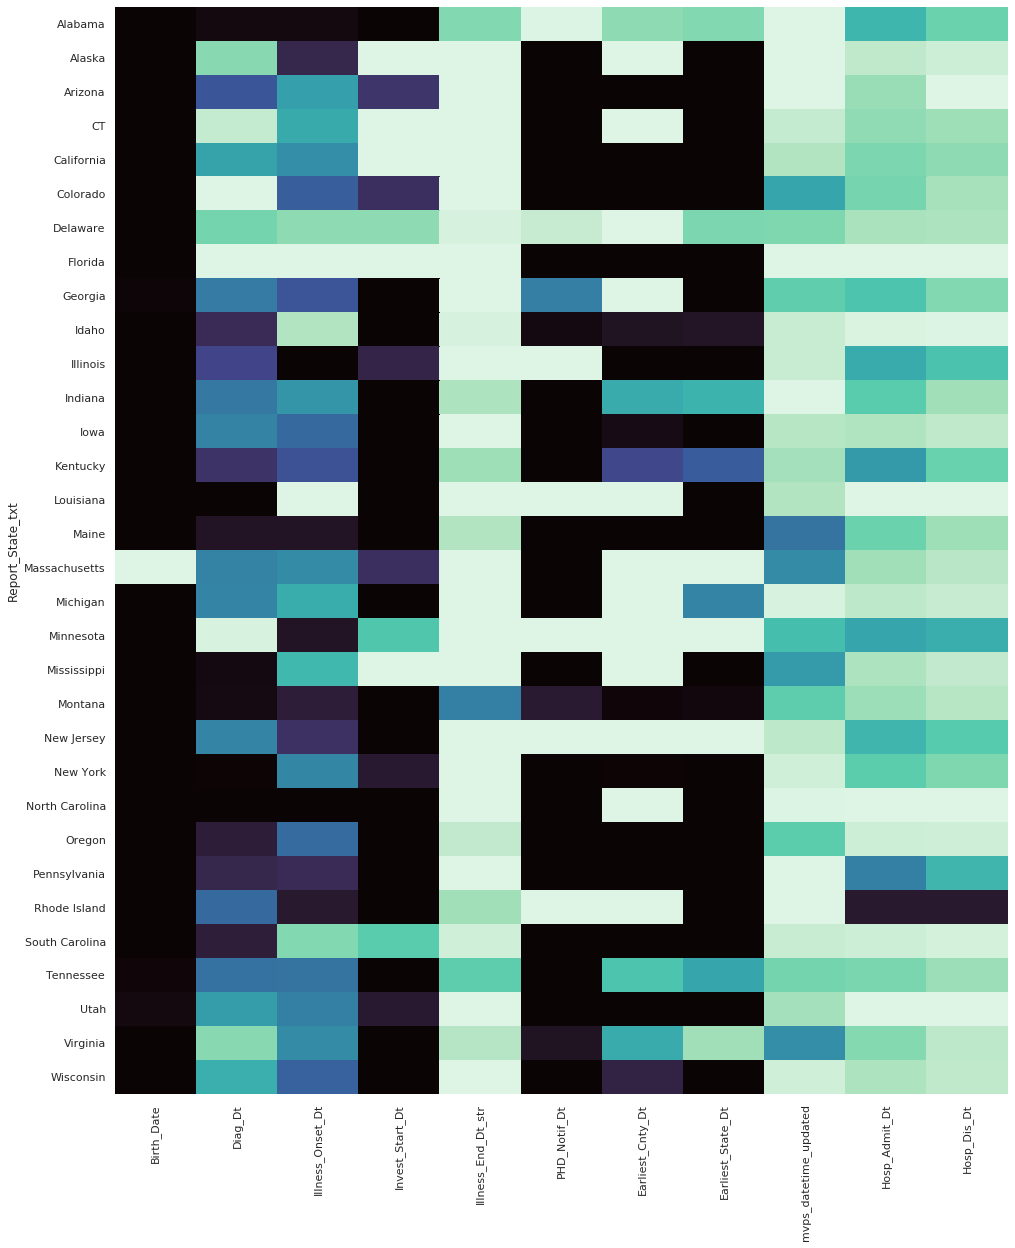

In [17]:
sns.set(rc={'figure.figsize':(16,20)})
sns.heatmap(missing_by_jurisdiction.drop(columns='sample_size'), cbar = False, cmap = "mako").figure.savefig("./figures/missing_by_jurisdiction.png")

### Missingness by Condition and Jurisdiction

In [18]:
missing_by_condition_and_jurisdiction = pd.concat([dx_dj[y].apply(lambda x: sum(x.isnull()) / len(x) * 100) for y in missing], axis = 1)
missing_by_condition_and_jurisdiction['sample_size'] = dx_dj.size().values
missing_by_condition_and_jurisdiction

Birth_Date  \
Report_State_txt Condition_Code_txt                                               
Alabama          Giardiasis                                            0.000000   
                 Legionellosis                                         0.000000   
                 Leptospirosis                                         0.000000   
Alaska           Brucellosis                                           0.000000   
                 Campylobacteriosis                                    0.000000   
                 Coccidioidomycosis                                    0.000000   
                 Cryptosporidiosis                                     0.000000   
                 Cyclosporiasis                                        0.000000   
                 Diphtheria                                            0.000000   
                 Giardiasis                                            0.000000   
                 Hansen disease (Leprosy)                              0.000000   
                 Hemolytic uremic syndrome postdiarrheal               0.000000   
                 Legionellosis                                         0.000000   
                 Malaria                                               0.000000   
                 Paratyphoid fever                                     0.000000   
                 Salmonellosis                                         0.000000   
                 Shiga toxin-producing Escherichia coli (STEC)         0.000000   
                 Shigellosis                                           0.000000   
                 Tetanus                                               0.000000   
                 Trichinellosis                                        0.000000   
                 Tularemia                                             0.000000   
                 Typhoid Fever?                                        0.000000   
                 Typhoid fever (caused by Salmonella typhi)            0.000000   
                 Vibriosis (non-cholera Vibrio species infections)     0.000000   
Arizona          Coccidioidomycosis                                    0.000000   
                 Corona virus                                          0.000000   
                 Shigellosis                                           0.000000   
CT               Anaplasma phagocytophilum                             0.000000   
                 Babesiosis                                            0.000000   
                 Campylobacteriosis                                    0.000000   
                 Chlamydia trachomatis infection                       0.097466   
                 Cryptosporidiosis                                     0.000000   
                 Cyclosporiasis                                        0.000000   
                 Ehrlichia chaffeensis                                 0.000000   
                 Giardiasis                                            0.000000   
                 Gonorrhea                                             0.197889   
                 Hansen disease (Leprosy)                              0.000000   
                 Hemolytic uremic syndrome postdiarrheal               0.000000   
                 Legionellosis                                         0.000000   
                 Malaria                                               0.000000   
                 Paratyphoid Fever                                     0.000000   
                 Paratyphoid Fever (cause by Salmonella Paratyph...    0.000000   
                 Salmonellosis                                         0.000000   
                 Shiga toxin-producing Escherichia coli (STEC)         0.000000   
                 Shigellosis                                           0.000000   
                 Spotted Fever Rickettsiosis                           0.000000   
                 Streptococcal toxic shock syndrome                    0.000000   
  

In [19]:
# Export table
missing_by_condition_and_jurisdiction.to_csv('./datasets/missing_by_jurisdiction.csv')

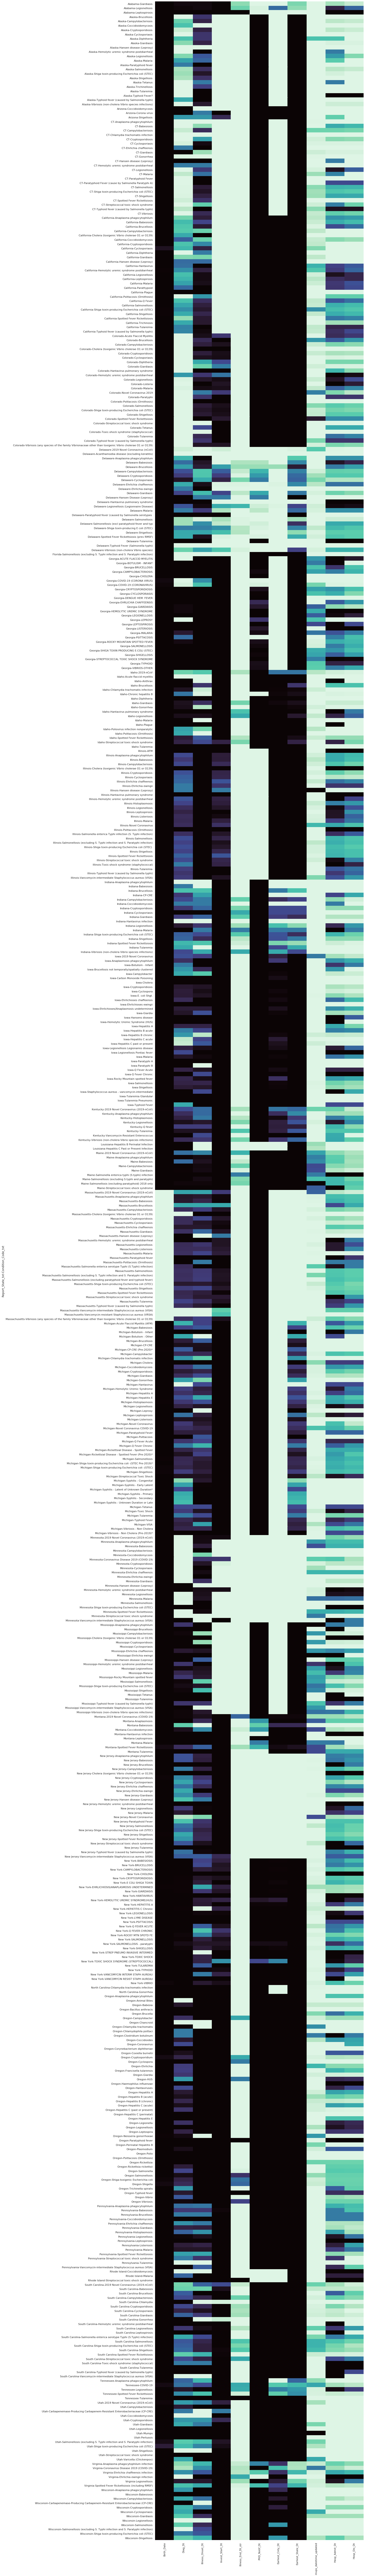

In [20]:
sns.set(rc={'figure.figsize':(16,200)})
sns.heatmap(missing_by_condition_and_jurisdiction.drop(columns='sample_size'), cbar = False, cmap = "mako").figure.savefig("./figures/missing_by_condition_jurisdiction.png")

### Missingness by Jurisdiction and Condition

In [21]:
missing_by_jurisdiction_and_condition = pd.concat([dj_dx[y].apply(lambda x: sum(x.isnull()) / len(x) * 100) for y in missing], axis = 1)
missing_by_jurisdiction_and_condition['sample_size'] = dj_dx.size().values
missing_by_jurisdiction_and_condition

Birth_Date  \
Condition_Code_txt                                 Report_State_txt               
2019 Novel Coronavirus                             Iowa                0.000000   
2019 Novel Coronavirus (2019-nCoV)                 Kentucky            0.518135   
                                                   Maine               0.383142   
                                                   Massachusetts     100.000000   
                                                   Minnesota           0.000000   
                                                   South Carolina      0.000000   
                                                   Utah                1.612903   
2019 Novel Coronavirus (COVID-19)                  Montana             0.000000   
2019 Novel Coronavirus (nCoV)                      Delaware            0.000000   
2019-nCoV                                          Idaho               0.386100   
ACUTE FLACCID MYELITIS                             Georgia             0.000000   
AFM                                                Illinois            0.000000   
Acanthamoeba disease (excluding keratitis)         Delaware            0.000000   
Acute Flaccid Myelitis                             Colorado            0.000000   
Acute Flaccid Myelitis (AFM)                       Michigan            0.000000   
Acute flaccid myelitis                             Idaho               0.000000   
Anaplasma phagocytophilum                          CT                  0.000000   
                                                   California          0.000000   
                                                   Delaware            0.000000   
                                                   Illinois            0.000000   
                                                   Indiana             0.000000   
                                                   Kentucky            0.000000   
                                                   Maine               0.000000   
                                                   Massachusetts     100.000000   
                                                   Minnesota           0.000000   
                                                   Mississippi         0.000000   
                                                   New Jersey          0.000000   
                                                   Oregon              0.000000   
                                                   Pennsylvania        0.000000   
                                                   Tennessee           0.000000   
                                                   Wisconsin           0.000000   
Anaplasma phagocytophilum infection                Virginia            0.000000   
Anaplasmosis                                       Montana             0.000000   
Anaplasmosis phagocytophilum                       Iowa                0.000000   
Animal Bites                                       Oregon              0.000000   
Anthrax                                            Idaho               0.000000   
BABESIOSIS                                         New York            0.000000   
BOTULISM - INFANT                                  Georgia             0.000000   
BRUCELLOSIS                                        Georgia             0.000000   
                                                   New York            0.000000   
Babesia                                            Oregon              0.000000   
Babesiosis                                         CT                  0.000000   
                                                   California          0.000000   
                                                   Delaware            0.000000   
                                                   Illinois            0.000000   
                                                   Indiana             0.000000   
                                                   Maine               0.000000   
  

In [22]:
# Export table
missing_by_jurisdiction_and_condition.to_csv('./datasets/missing_by_jurisdiction_and_condition.csv')

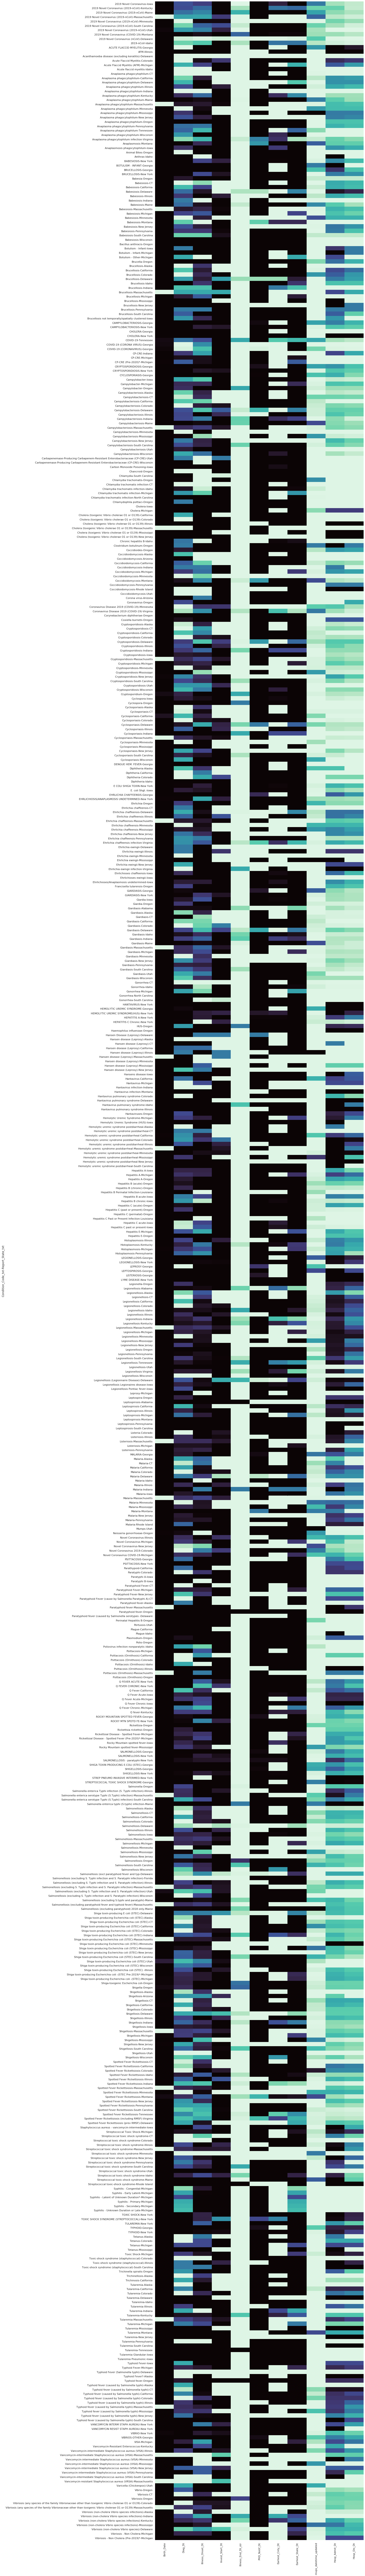

In [23]:
sns.set(rc={'figure.figsize':(16,200)})
sns.heatmap(missing_by_jurisdiction_and_condition.drop(columns='sample_size'), cbar = False, cmap = "mako").figure.savefig("./figures/missing_by_jurisdiction_condition.png")

## Date Sequences
For any two date variable tuples (a, b), whenever both a and b are present, is a < b?

In [24]:
# Gather date tuples
date_tuples = list(combinations(list(set(date_vars) - set(['current_record_flag', 'Report_State_txt', 'Condition_Code_txt'])), 2))
date_tuples

[('Message_Dt', 'Birth_Date'),
 ('Message_Dt', 'Report_Dt'),
 ('Message_Dt', 'First_Elec_Submit_Dt'),
 ('Message_Dt', 'Illness_Onset_Dt'),
 ('Message_Dt', 'Invest_Start_Dt'),
 ('Message_Dt', 'Illness_End_Dt_str'),
 ('Message_Dt', 'PHD_Notif_Dt'),
 ('Message_Dt', 'Earliest_Cnty_Dt'),
 ('Message_Dt', 'mvps_datetime_created'),
 ('Message_Dt', 'Elect_Notif_CDC_Dt'),
 ('Message_Dt', 'Hosp_Admit_Dt'),
 ('Message_Dt', 'Diag_Dt'),
 ('Message_Dt', 'Hosp_Dis_Dt'),
 ('Message_Dt', 'msg_received_dttm'),
 ('Message_Dt', 'Earliest_State_Dt'),
 ('Message_Dt', 'mvps_datetime_updated'),
 ('Message_Dt', 'MMWR_Year'),
 ('Birth_Date', 'Report_Dt'),
 ('Birth_Date', 'First_Elec_Submit_Dt'),
 ('Birth_Date', 'Illness_Onset_Dt'),
 ('Birth_Date', 'Invest_Start_Dt'),
 ('Birth_Date', 'Illness_End_Dt_str'),
 ('Birth_Date', 'PHD_Notif_Dt'),
 ('Birth_Date', 'Earliest_Cnty_Dt'),
 ('Birth_Date', 'mvps_datetime_created'),
 ('Birth_Date', 'Elect_Notif_CDC_Dt'),
 ('Birth_Date', 'Hosp_Admit_Dt'),
 ('Birth_Date', 'Diag_Dt'

In [25]:
# Date parsing utility function for the function to follow
def dateParse(df, x):
    
    # It seems that illness_end_dt_str are formatted as YYYYMMDD, while other datetime variables are YYYY-MM-DD.
    # However, there are other peculiaries, such as illness_end_dt_str ending in .000 and datetime variables
    # requiring their time component to be stripped away, which is hanlded by the string slicing below.
    if x == 'Illness_End_Dt_str':
        return pd.to_datetime(df[x].str.slice(start = 0, stop = 8), errors='coerce', format = '%Y%m%d')
    else:
        return pd.to_datetime(df[x].str.slice(start = 0, stop = 10), errors='coerce', format = '%Y-%m-%d')

In [26]:
# Function to process a date tuple and assess how often both dates were present, and if they were, how often a < b
def processTuple(tup):
    
    # Unpack
    a, b = tup
       
    # Subset the data to complete cases (both a and b exist)
    sub = core_dts[[a,b]] 
    sub_complete = sub.loc[~(sub[a].isna() | sub[b].isna()), :]
    
    # Capture the sample size of this and the percentage of the data this represents
    complete_cases = sub_complete.shape[0]
    complete_case_pct = round(complete_cases / sub.shape[0] * 100,2)
    
    # Depending on the variable type, it needs to be converted to a date differently because the dates are in varying formats
    a_dates = dateParse(sub_complete, a)
    b_dates = dateParse(sub_complete, b)
    
    # Subtract and convert date differences to days
    a_b = (a_dates - b_dates) / np.timedelta64(1, 'D')
    
    # Gather statistics about this difference
    a_b_mean   = a_b.mean()
    a_b_std    = a_b.std()
    a_b_median = a_b.median()
    a_b_min    = a_b.min()
    a_b_max    = a_b.max()
    a_b_l95    = a_b.quantile(0.025)
    a_b_u95    = a_b.quantile(0.975)
    
    # Pass back a dataframe containing all difference information
    return pd.DataFrame(data = {'Date1':[a],
                                'Date2':[b],
                                'Complete_Cases':[complete_cases],
                                'Complete_Case_Pct':[complete_case_pct],
                                'Min':[a_b_min],
                                'Max':[a_b_max],
                                'Mean':[a_b_mean],
                                'Std':[a_b_std],
                                'Median':[a_b_median],
                                'L95':[a_b_l95],
                                'U95':[a_b_u95]})
    

In [27]:
# Example of use of this function on a single tuple
processTuple(('Illness_Onset_Dt','Hosp_Dis_Dt'))

Date1        Date2  Complete_Cases  Complete_Case_Pct      Min  \
0  Illness_Onset_Dt  Hosp_Dis_Dt           54502               5.78 -32882.0   

       Max     Mean        Std  Median   L95  U95  
0  43868.0 -9.45656  388.64615    -7.0 -37.0 -1.0

In [28]:
# Call this on all date combination tuples
date_sequences = pd.concat([processTuple(x) for x in date_tuples])

In [29]:
# Show the distributions of pairwise date differences (Date1 - Date2)
# i.e. NEGATIVE differences imply Date1 came BEFORE Date2
#      POSITIVE differences imply Date1 came AFTER  Date2
date_sequences

Date1                  Date2  Complete_Cases  \
0             Message_Dt             Birth_Date          865509   
0             Message_Dt              Report_Dt          942582   
0             Message_Dt   First_Elec_Submit_Dt          942582   
0             Message_Dt       Illness_Onset_Dt          507592   
0             Message_Dt        Invest_Start_Dt          743535   
0             Message_Dt     Illness_End_Dt_str            8415   
0             Message_Dt           PHD_Notif_Dt          843807   
0             Message_Dt       Earliest_Cnty_Dt          372103   
0             Message_Dt  mvps_datetime_created          942582   
0             Message_Dt     Elect_Notif_CDC_Dt          942582   
0             Message_Dt          Hosp_Admit_Dt           81267   
0             Message_Dt                Diag_Dt          645161   
0             Message_Dt            Hosp_Dis_Dt           60418   
0             Message_Dt      msg_received_dttm          942582   
0             Message_Dt      Earliest_State_Dt          739578   
0             Message_Dt  mvps_datetime_updated           97030   
0             Message_Dt              MMWR_Year          942306   
0             Birth_Date              Report_Dt          865509   
0             Birth_Date   First_Elec_Submit_Dt          865509   
0             Birth_Date       Illness_Onset_Dt          473255   
0             Birth_Date        Invest_Start_Dt          683700   
0             Birth_Date     Illness_End_Dt_str            8381   
0             Birth_Date           PHD_Notif_Dt          767044   
0             Birth_Date       Earliest_Cnty_Dt          371574   
0             Birth_Date  mvps_datetime_created          865509   
0             Birth_Date     Elect_Notif_CDC_Dt          865509   
0             Birth_Date          Hosp_Admit_Dt           72919   
0             Birth_Date                Diag_Dt          609241   
0             Birth_Date            Hosp_Dis_Dt           54940   
0             Birth_Date      msg_received_dttm          865509   
0             Birth_Date      Earliest_State_Dt          738683   
0             Birth_Date  mvps_datetime_updated           63088   
0             Birth_Date              MMWR_Year          865233   
0              Report_Dt   First_Elec_Submit_Dt          942582   
0              Report_Dt       Illness_Onset_Dt          507592   
0              Report_Dt        Invest_Start_Dt          743535   
0              Report_Dt     Illness_End_Dt_str            8415   
0              Report_Dt           PHD_Notif_Dt          843807   
0              Report_Dt       Earliest_Cnty_Dt          372103   
0              Report_Dt  mvps_datetime_created          942582   
0              Report_Dt     Elect_Notif_CDC_Dt          942582   
0              Report_Dt          Hosp_Admit_Dt           81267   
0              Report_Dt                Diag_Dt          645161   
0              Report_Dt            Hosp_Dis_Dt           60418   
0              Report_Dt      msg_received_dttm          942582   
0              Report_Dt      Earliest_State_Dt          739578   
0              Report_Dt  mvps_datetime_updated           97030   
0              Report_Dt              MMWR_Year          942306   
0   First_Elec_Submit_Dt       Illness_Onset_Dt          507592   
0   First_Elec_Submit_Dt        Invest_Start_Dt          743535   
0   First_Elec_Submit_Dt     Illness_End_Dt_str            8415   
0   First_Elec_Submit_Dt           PHD_Notif_Dt          843807   
0   First_Elec_Submit_Dt       Earliest_Cnty_Dt          372103   
0   First_Elec_Submit_Dt  mvps_datetime_created          942582   
0   First_Elec_Submit_Dt     Elect_Notif_CDC_Dt          942582   
0   First_Elec_Submit_Dt          Hosp_Admit_Dt           81267   
0   First_Elec_Submit_Dt                Diag_Dt          645161   
0   First_Elec_Submit_Dt            Hosp_Dis_Dt           60418   
0   First_Elec_Submit_Dt      msg_received_dttm          942582   

In [30]:
# Export table
date_sequences.to_csv('./datasets/date_sequence_distributions.csv', index = False)